## EDA - carga de data y revision de variables

In [1]:
%load_ext autoreload
%autoreload 2
import mlflow, matplotlib.pyplot as plt, seaborn as sns, numpy as np, pandas as pd, missingno as msno
from src.logging_utils import setup_logger
from src.mlflow_setup import setup_mlflow
from src.eda_utils import *

logger = setup_logger("eda")
sns.set(style="whitegrid")
setup_mlflow("eda-baseline")
run = mlflow.start_run(run_name="eda_v2")

2025-07-31 11:49:09.066 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: /home/fernando/Documentos/insurance-mlops


In [2]:
df = read_raw("../data/raw/train.csv")
logger.info(f"Raw shape: {df.shape}")
df = coerce_types(df)
df = parse_dates(df)
report = basic_quality_report(df)

2025-07-31 11:49:11.938 | INFO     | __main__:<module>:2 - Raw shape: (1200000, 21)
2025-07-31 11:49:11 | INFO | Raw shape: (1200000, 21)


In [3]:
report

,feature,dtype,n_unique,n_missing,pct_missing
11,Previous Claims,float64,10,364029,30.34
7,Occupation,category,3,358075,29.84
13,Credit Score,float64,550,137882,11.49
5,Number of Dependents,float64,5,109672,9.14
16,Customer Feedback,category,3,77824,6.49
8,Health Score,float64,532657,74076,6.17
3,Annual Income,float64,88593,44949,3.75
1,Age,float64,47,18705,1.56
4,Marital Status,category,3,18529,1.54
2,Gender,category,2,0,0.00


In [4]:
report.to_csv("../reports/eda_quality_report.csv", index=False)
mlflow.log_artifact("../reports/eda_quality_report.csv")

In [5]:
df['Customer Feedback'].value_counts()

Customer Feedback
Average    377905
Poor       375518
Good       368753
Name: count, dtype: int64

In [6]:
order = ["Poor","Average","Good"]
df["Customer Feedback"] = (
    df["Customer Feedback"].astype(str).str.strip().str.title().replace({"Nan": np.nan})
)
df["Customer Feedback"] = df["Customer Feedback"].fillna("Unknown")

stats = (df.groupby("Customer Feedback")["Premium Amount"]
           .agg(["count","mean","median"])
           .reindex(order + ["Unknown"], fill_value=0))
display(stats)

# ¿Monotónico?
monotonic = stats.loc[order, "median"].is_monotonic_increasing
mlflow.log_params({"customer_feedback_monotonic": bool(monotonic)})

if monotonic:
    df["CustomerFeedbackOrd"] = pd.Categorical(df["Customer Feedback"], categories=order, ordered=True).codes
    mlflow.log_params({"customer_feedback_treatment": "ordinal"})
else:
    mlflow.log_params({"customer_feedback_treatment": "nominal"})

,count,mean,median
Customer Feedback,,,
Poor,375518,1098.892745,868.0
Average,377905,1094.350977,861.0
Good,368753,1096.284299,861.0
Unknown,77824,1189.619526,956.0


## Revision de nulos

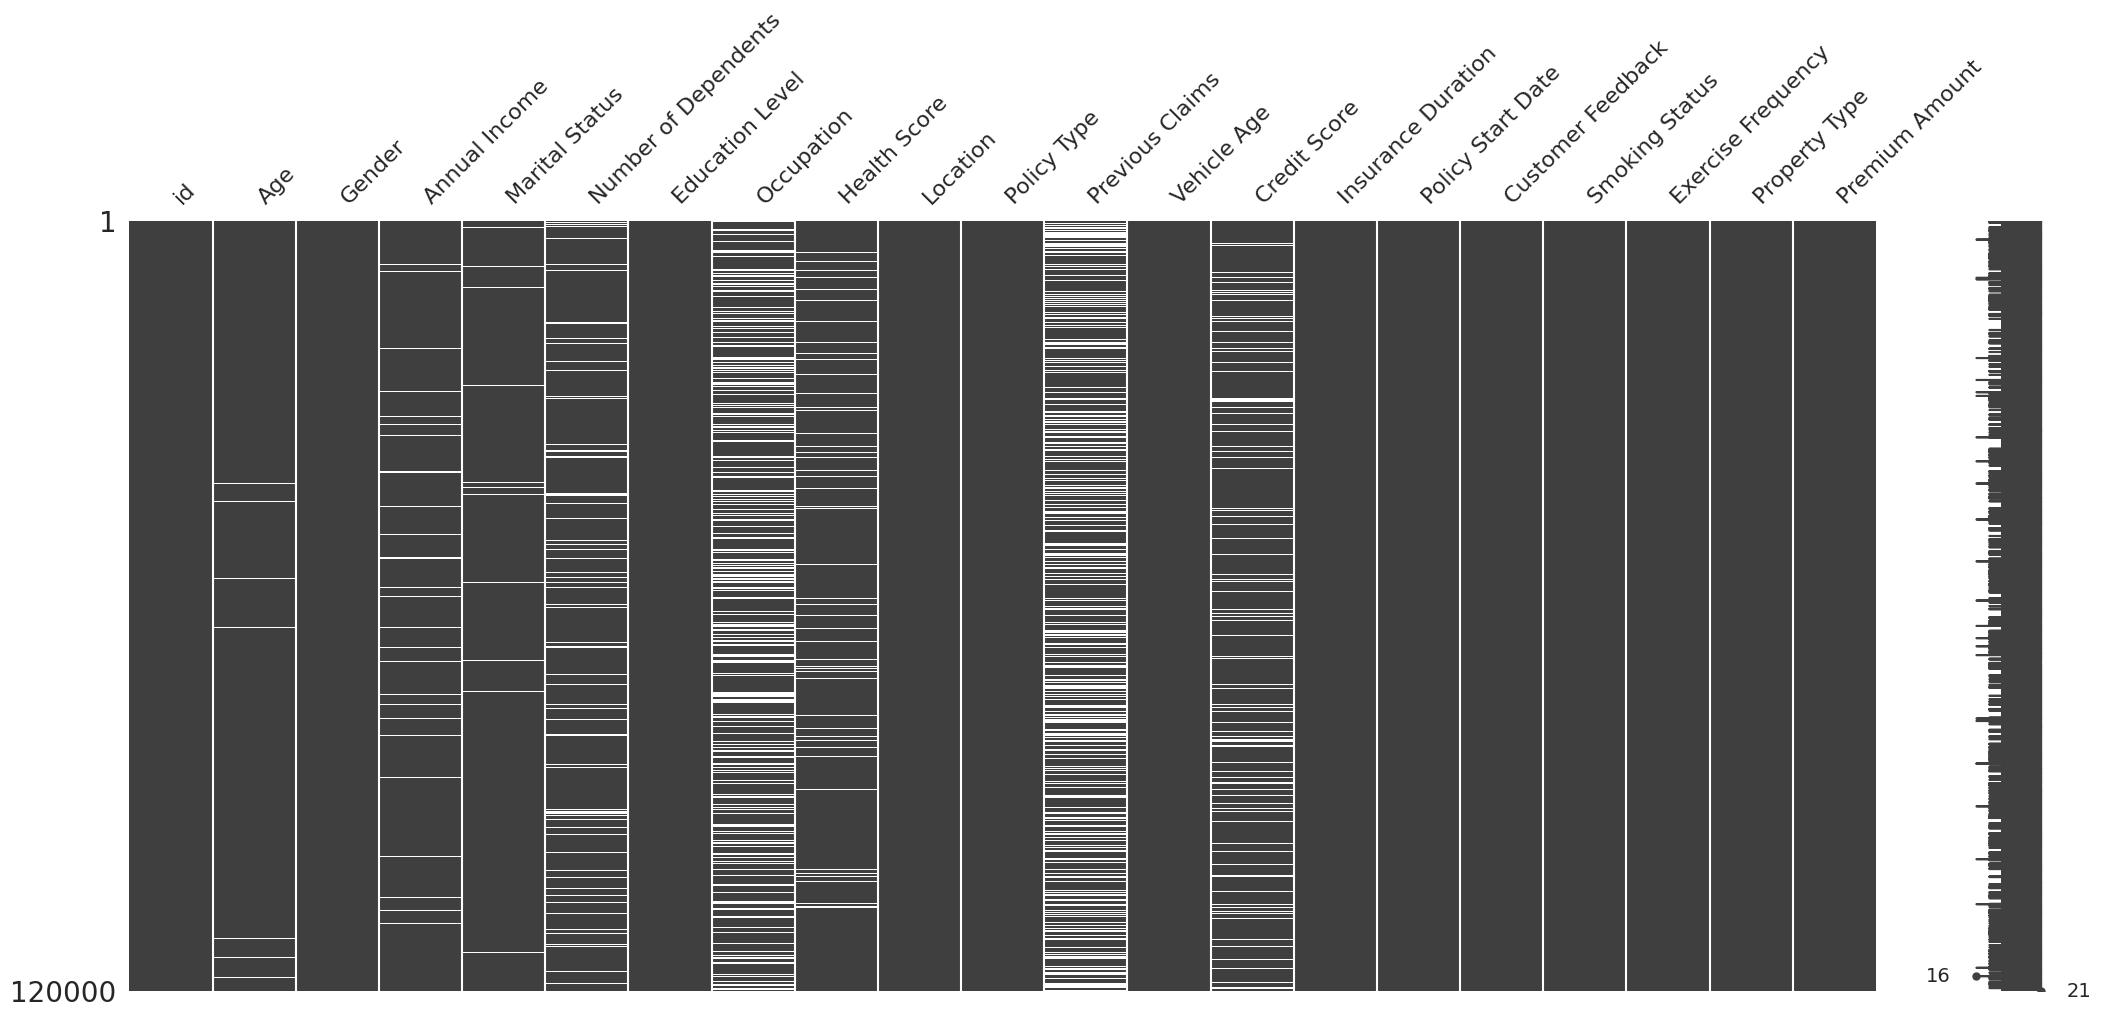

In [7]:
# revisando una muestra de la data train
ax = msno.matrix(df.sample(120_000))

In [8]:
#ax.figure.savefig("../reports/eda_missing_matrix.png", dpi=150, bbox_inches="tight")

In [9]:
mlflow.log_figure(ax.figure, "eda_missing_matrix.png")

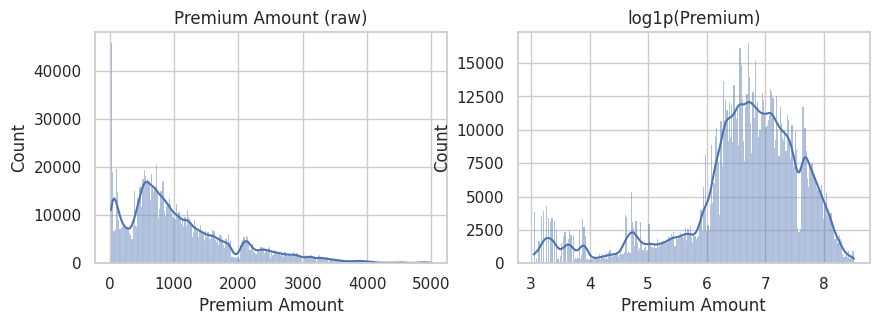

In [10]:
fig, ax = plt.subplots(1,2, figsize=(10,3))
sns.histplot(df[TARGET], kde=True, ax=ax[0]); ax[0].set_title("Premium Amount (raw)")
sns.histplot(np.log1p(df[TARGET]), kde=True, ax=ax[1]); ax[1].set_title("log1p(Premium)");

In [11]:
checks = rmsle_safe_check(df, TARGET)

In [12]:
checks

{'hay_negativos': False, 'no_finito': 0}

In [13]:
mlflow.log_params({"target_has_negative": checks["hay_negativos"], "target_non_finite": checks["no_finito"]})
logger.info(f"RMSLE checks: {checks}")
# Decisión: optimizar RMSLE → entrenar sobre log1p(y) y retransformar al evaluar.

2025-07-31 11:49:22.733 | INFO     | __main__:<module>:2 - RMSLE checks: {'hay_negativos': False, 'no_finito': 0}
2025-07-31 11:49:22 | INFO | RMSLE checks: {'hay_negativos': False, 'no_finito': 0}


## Categoricas

In [14]:
cat_cols = df.select_dtypes(include=["category"]).columns.tolist()
card = df[cat_cols].nunique().sort_values(ascending=False)

In [15]:
(
    card.rename("cardinality")
        .rename_axis("feature")
        .reset_index()
        .to_csv("../reports/eda_cat_cardinality.csv", index=False)
)

In [16]:
mlflow.log_artifact("../reports/eda_cat_cardinality.csv")

In [17]:
card

Education Level       4
Exercise Frequency    4
Location              3
Occupation            3
Marital Status        3
Property Type         3
Policy Type           3
Gender                2
Smoking Status        2
dtype: int64

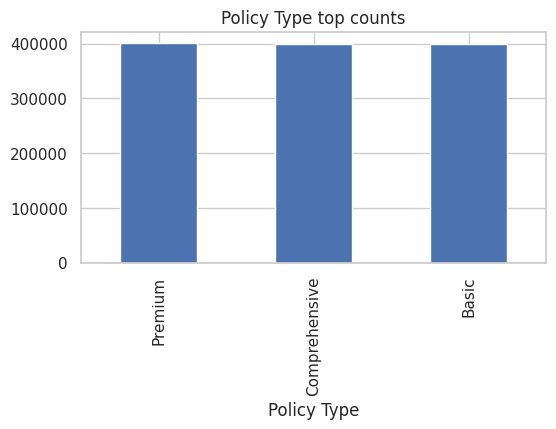

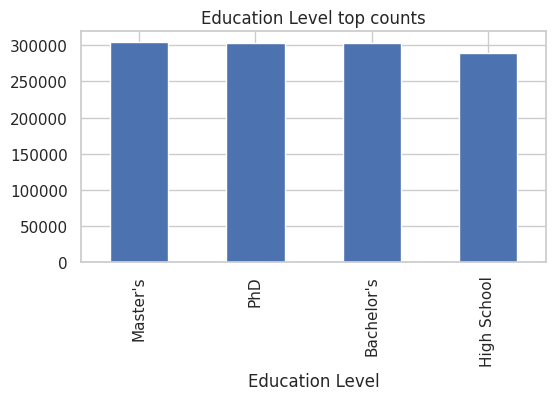

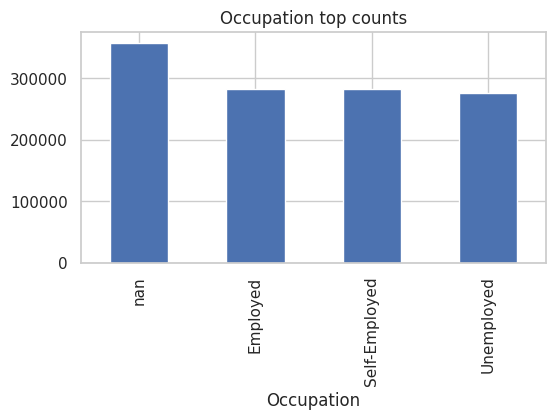

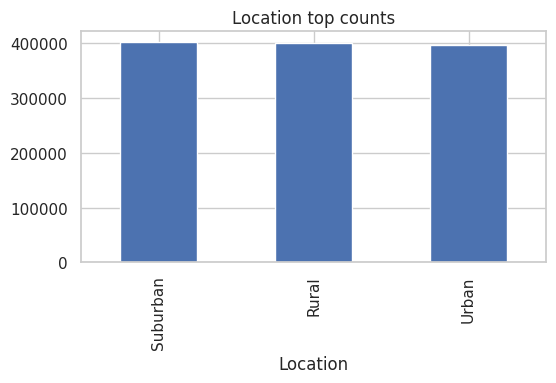

In [18]:
for c in ["Policy Type","Education Level","Occupation","Location"]:
    if c in df.columns:
        ax = df[c].value_counts(dropna=False).plot.bar(figsize=(6,3), title=f"{c} top counts")
        # plt.tight_layout(); 
        plt.savefig(f"../reports/eda_{c}_counts.png", dpi=150)
        mlflow.log_artifact(f"../reports/eda_{c}_counts.png")
        plt.show()

# Decisiones:
# One-hot/target encoding

## Numericas

In [19]:
df = datetime_features(df)
num_cols = df.select_dtypes(include=[np.number]).columns.drop([TARGET, "id"], errors="ignore")

desc = df[num_cols].describe().T.sort_values("std", ascending=False)

In [20]:
desc.to_csv("../reports/eda_num_desc.csv");
mlflow.log_artifact("../reports/eda_num_desc.csv")
desc

,count,mean,std,min,25%,50%,75%,max
Annual Income,1155051.0,32745.217777,32179.506124,1.000000,8001.000000,2.391100e+04,44634.000000,149997.000000
Credit Score,1062118.0,592.924350,149.981945,300.000000,468.000000,5.950000e+02,721.000000,849.000000
Age,1181295.0,41.145563,13.539950,18.000000,30.000000,4.100000e+01,53.000000,64.000000
Health Score,1125924.0,25.613908,12.203462,2.012237,15.918959,2.457865e+01,34.527209,58.975914
Vehicle Age,1199994.0,9.569889,5.776189,0.000000,5.000000,1.000000e+01,15.000000,19.000000
Policy Start Date_month,1200000.0,6.492671,3.432689,1.000000,4.000000,6.000000e+00,9.000000,12.000000
Insurance Duration,1199999.0,5.018219,2.594331,1.000000,3.000000,5.000000e+00,7.000000,9.000000
Policy Start Date_dow,1200000.0,2.994127,2.002287,0.000000,1.000000,3.000000e+00,5.000000,6.000000
Policy Start Date_year,1200000.0,2021.620870,1.476008,2019.000000,2020.000000,2.022000e+03,2023.000000,2024.000000
Number of Dependents,1090328.0,2.009934,1.417338,0.000000,1.000000,2.000000e+00,3.000000,4.000000


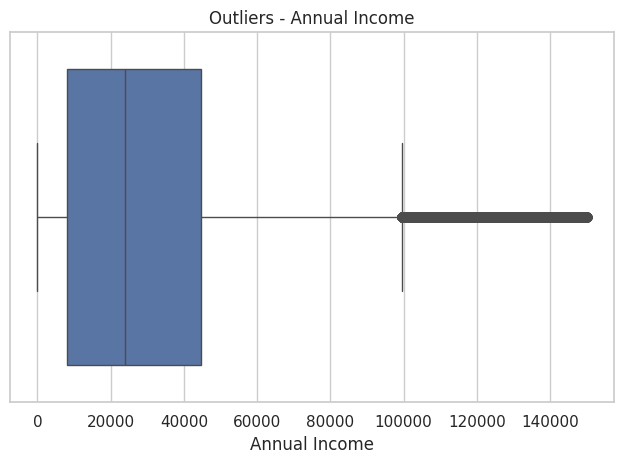

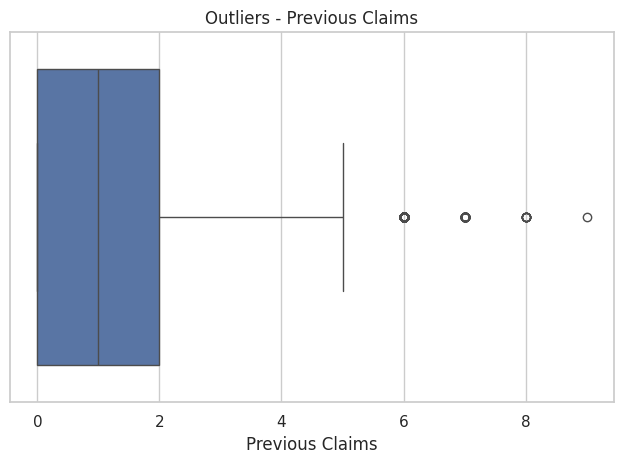

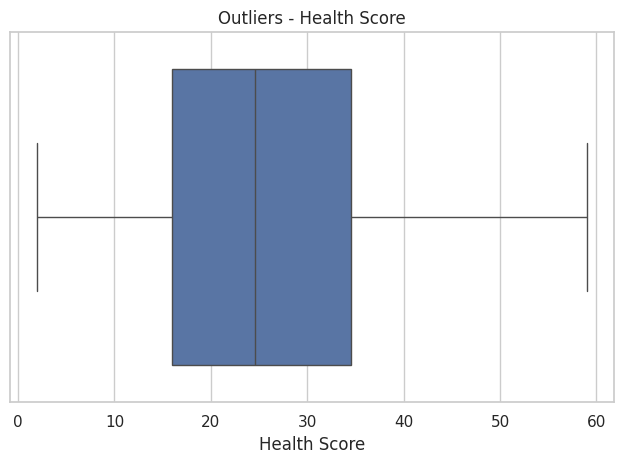

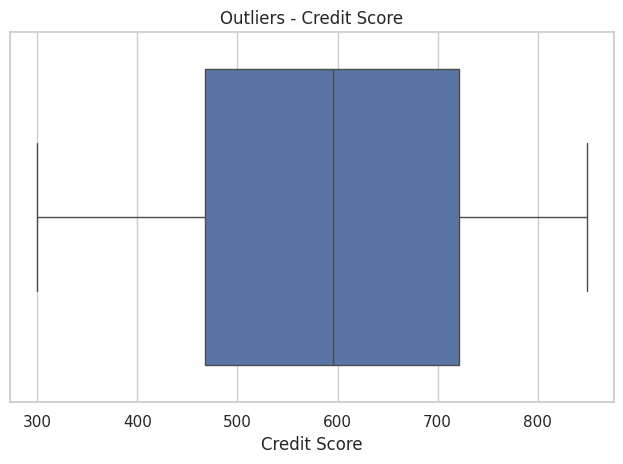

In [21]:
for c in ["Annual Income","Previous Claims","Health Score","Credit Score"]:
    # if c in df.columns:
    sns.boxplot(x=df[c]); plt.title(f"Outliers - {c}")
    plt.tight_layout()
    plt.savefig(f"../reports/eda_outliers_{c}.png", dpi=150)
    mlflow.log_artifact(f"../reports/eda_outliers_{c}.png")
    plt.show()

# Decisiones:
# - Winsorize p99 en 'Annual Income' y 'Previous Claims'.

## PCA y UMAP

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap

/home/fernando/Documentos/insurance-mlops/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
X = df[num_cols].fillna(df[num_cols].median())
X_s = StandardScaler().fit_transform(X)

Text(0, 0.5, 'cum var')

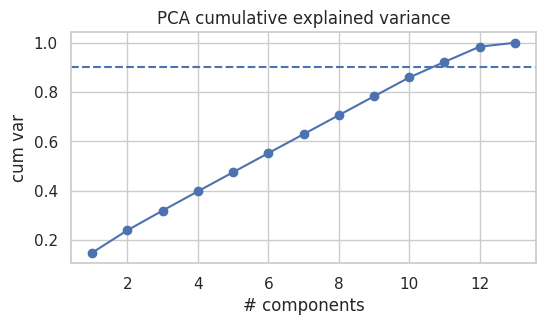

In [24]:
pca = PCA().fit(X_s); expl = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(6,3))
plt.plot(np.arange(1,len(expl)+1), expl, marker="o"); plt.axhline(0.9, ls="--")
plt.title("PCA cumulative explained variance"); plt.xlabel("# components"); plt.ylabel("cum var")

/home/fernando/Documentos/insurance-mlops/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


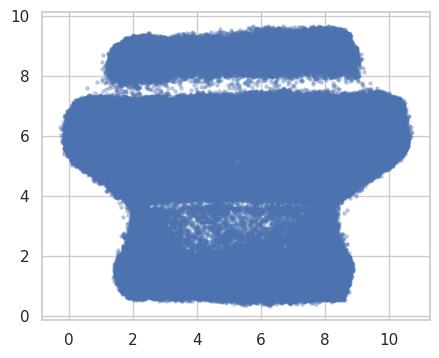

In [30]:
rng = np.random.default_rng(42)
idx_fit = rng.choice(len(X_s), size=200_000, replace=False)
X_fit = X_s[idx_fit]

um = umap.UMAP(n_components=2, n_neighbors=15, metric="euclidean")
Z = um.fit_transform(X_fit)
plt.figure(figsize=(5,4)); plt.scatter(Z[:,0], Z[:,1], s=5, alpha=0.3);

In [26]:
len(Z)

200000

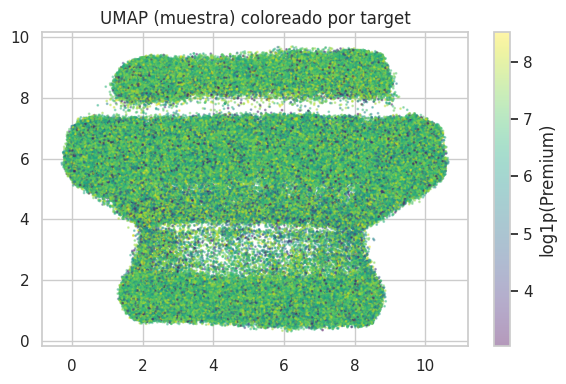

In [27]:
logy = np.log1p(df[TARGET])  # mejor para RMSLE
plt.figure(figsize=(6,4))
sc = plt.scatter(Z[:,0], Z[:,1], c=logy[idx_fit], s=1, alpha=0.4, cmap="viridis")
plt.colorbar(sc, label="log1p(Premium)")
plt.title("UMAP (muestra) coloreado por target")
plt.tight_layout(); plt.show()

In [28]:
# Ni componentes principales ni UMAP dan evidencia de poder usarlos en la creación de features

In [29]:
mlflow.log_artifact("logs/eda.log")
mlflow.end_run()

🏃 View run eda_v2 at: https://dagshub.com/fertueros/insurance-mlops.mlflow/#/experiments/0/runs/d1c091974ed047dcb8e6ba6b4763c25e
🧪 View experiment at: https://dagshub.com/fertueros/insurance-mlops.mlflow/#/experiments/0
